In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

data_path="E:\\5 Code\\2025_cu_qmim\\data" #修改为data存储路径

metric_data=os.path.join(data_path,'price_metrics.parquet')
std_data=os.path.join(data_path,'factors_std.parquet')
px_all = pd.read_parquet(metric_data)
factors_std = pd.read_parquet(std_data)

# Extract PX_LAST only (MultiIndex columns)
px = px_all.xs("PX_LAST", axis=1, level="metric")


In [2]:

def calc_ret(df, px):
    # df: weights (index=rebalance date, columns=tickers)
    # px: daily price (index=daily dates, columns=tickers)
    l = df.abs().sum(axis=1).fillna(0)
    w_df = df.div(l, axis=0)  # 归一化权重
    ret_df = px.pct_change()
    w_d = w_df.reindex(ret_df.index, method="ffill").fillna(0)
    ret = (w_d * ret_df).dropna(how='all').sum(axis=1)
    return ret

def compute_stats_daily(ret_series, periods_per_year=252):
    r = ret_series.dropna()
    if len(r) == 0:
        return {
            "ann_ret": np.nan,
            "ann_vol": np.nan,
            "sharpe": np.nan,
            "max_drawdown": np.nan,
        }

    n = len(r)
    # Equity curve
    eq = (1.0 + r).cumprod()

    # Annualised return
    ann_ret = eq.iloc[-1] ** (periods_per_year / n) - 1.0

    # Annualised vol
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)

    sharpe = ann_ret / ann_vol if (ann_vol not in [0, np.nan]) else np.nan

    # Max drawdown
    running_max = eq.cummax()
    dd = eq / running_max - 1.0
    max_dd = dd.min()

    return {
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

# 价格区间
price_df = px.loc[(px.index >= "2012-11-30") & (px.index <= "2020-12-31")]


C:\Users\25188\AppData\Local\Temp\ipykernel_64004\4078566221.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = px.pct_change()
C:\Users\25188\AppData\Local\Temp\ipykernel_64004\4078566221.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = px.pct_change()
C:\Users\25188\AppData\Local\Temp\ipykernel_64004\4078566221.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_d

Performance stats (daily-based):
             ann_ret   ann_vol    sharpe  max_drawdown
w_10_2     -0.002781  0.016167 -0.172028     -0.039754
worig_10_2  0.014266  0.051227  0.278487     -0.083218
w_10_6      0.003873  0.016554  0.233950     -0.043064
worig_10_6  0.017287  0.046879  0.368764     -0.090190
w_5_2      -0.004212  0.017333 -0.243011     -0.051452
worig_5_2   0.014668  0.054541  0.268931     -0.101899
w_5_12      0.000194  0.019977  0.009703     -0.063645
worig_5_12  0.004967  0.045270  0.109711     -0.156021
w_30_2     -0.010411  0.016510 -0.630581     -0.099674
worig_30_2  0.023636  0.043634  0.541693     -0.074140
w_30_4      0.009842  0.017854  0.551229     -0.030008
worig_30_4  0.033666  0.049976  0.673653     -0.086992
w_60_2      0.003474  0.016569  0.209663     -0.054363
worig_60_2  0.023902  0.041870  0.570871     -0.063571
w_60_4      0.009266  0.017106  0.541704     -0.024882
worig_60_4  0.028059  0.042184  0.665160     -0.083732

Sharpe ranking:
worig_30_4    0

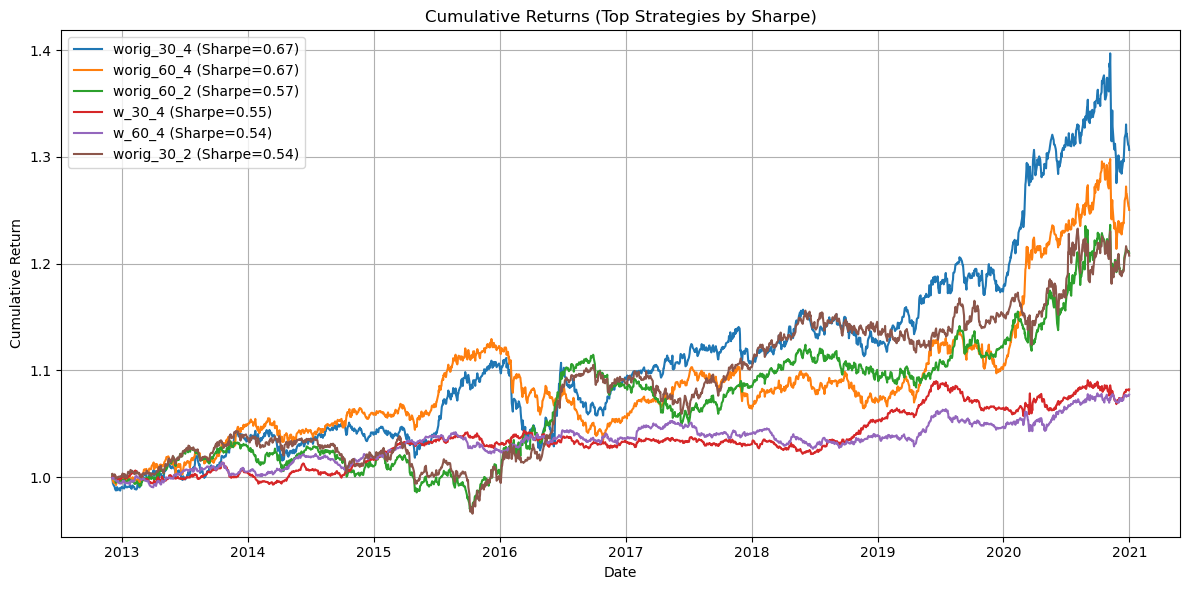

In [3]:
# 你之前跑的参数列表
param_lst = [(10,2),(10,6),(5,2),(5,12),(30,2),(30,4),(60,2),(60,4)]

all_stats = {}     # 存每个策略的绩效指标
all_eq_curves = {} # 存每个策略的累计收益曲线

for k, gap in param_lst:
    # 读取之前保存的权重文件
    w = pd.read_csv(f'weights_{k}_{gap}.csv', index_col=0, parse_dates=True)
    w_orig = pd.read_csv(f'weights_orig_{k}_{gap}.csv', index_col=0, parse_dates=True)

    # 计算日度收益
    ret1 = calc_ret(w, price_df)
    ret2 = calc_ret(w_orig, price_df)

    name1 = f'w_{k}_{gap}'
    name2 = f'worig_{k}_{gap}'

    # 计算统计指标
    stats1 = compute_stats_daily(ret1)
    stats2 = compute_stats_daily(ret2)

    all_stats[name1] = stats1
    all_stats[name2] = stats2

    # 累计收益曲线
    all_eq_curves[name1] = (1.0 + ret1).cumprod()
    all_eq_curves[name2] = (1.0 + ret2).cumprod()

# ===== 整理成 DataFrame，方便查看/排序 =====
stats_df = pd.DataFrame(all_stats).T  # index: 策略名，columns: ann_ret, ann_vol, sharpe, max_drawdown
print("Performance stats (daily-based):")
print(stats_df)

# 按 Sharpe 排序看一下
print("\nSharpe ranking:")
print(stats_df["sharpe"].sort_values(ascending=False))

# ===== 把所有策略的累计收益画在一个 plt 中 =====
plt.figure(figsize=(12, 6))

# 可以选择只画 Sharpe 前 N 名，避免太乱
top_n = 6
top_strats = stats_df["sharpe"].sort_values(ascending=False).index[:top_n]

for name in top_strats:
    eq = all_eq_curves[name]
    plt.plot(eq.index, eq.values, label=f"{name} (Sharpe={stats_df.loc[name,'sharpe']:.2f})")

plt.title("Cumulative Returns (Top Strategies by Sharpe)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\25188\AppData\Local\Temp\ipykernel_64004\3969576870.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = px.pct_change()
C:\Users\25188\AppData\Local\Temp\ipykernel_64004\3969576870.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = px.pct_change()
C:\Users\25188\AppData\Local\Temp\ipykernel_64004\3969576870.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret1_m = (1.0 + ret1_daily).resample('M').prod() - 1.0
C:\Users\25188\AppData\Local\Temp\ipykernel_64004\3969576870.py:68: FutureWarning: 'M' is depr

Performance stats (monthly-based):
             ann_ret   ann_vol    sharpe  max_drawdown
w_10_2     -0.002778  0.015790 -0.175961     -0.035609
worig_10_2  0.014252  0.044666  0.319081     -0.066039
w_10_6      0.003869  0.015429  0.250752     -0.037504
worig_10_6  0.017270  0.047429  0.364132     -0.078904
w_5_2      -0.004208  0.017292 -0.243352     -0.049388
worig_5_2   0.014653  0.049197  0.297847     -0.082662
w_5_12      0.000194  0.020543  0.009426     -0.061782
worig_5_12  0.004962  0.046562  0.106561     -0.139768
w_30_2     -0.010401  0.017224 -0.603835     -0.095099
worig_30_2  0.023613  0.038479  0.613653     -0.060520
w_30_4      0.009832  0.017073  0.575855     -0.024583
worig_30_4  0.033633  0.051547  0.652465     -0.070720
w_60_2      0.003470  0.016883  0.205554     -0.049622
worig_60_2  0.023879  0.036581  0.652753     -0.050417
w_60_4      0.009257  0.016393  0.564696     -0.021639
worig_60_4  0.028031  0.041322  0.678371     -0.072365

Sharpe ranking (monthly-based

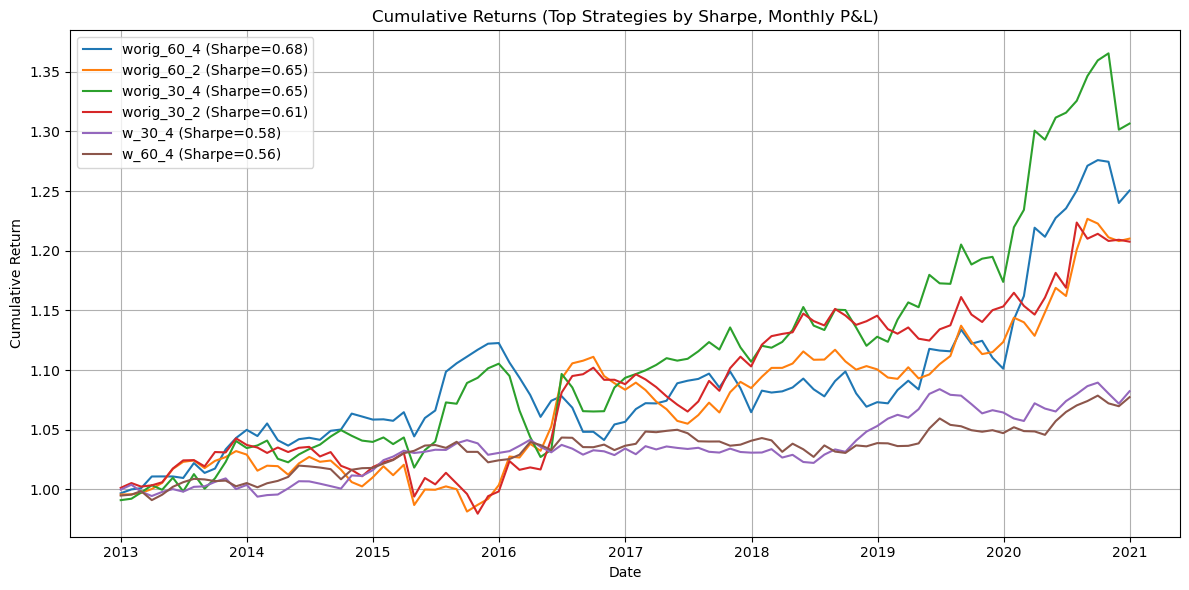

In [4]:
#if only look at monthly picture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calc_ret(df, px):
    l = df.abs().sum(axis=1).fillna(0)
    w_df = df.div(l, axis=0)
    ret_df = px.pct_change()
    w_d = w_df.reindex(ret_df.index, method="ffill").fillna(0)
    ret = (w_d * ret_df).dropna(how='all').sum(axis=1)
    return ret

def compute_stats(ret_series, periods_per_year):
    r = ret_series.dropna()
    if len(r) == 0:
        return {
            "ann_ret": np.nan,
            "ann_vol": np.nan,
            "sharpe": np.nan,
            "max_drawdown": np.nan,
        }

    n = len(r)
    eq = (1.0 + r).cumprod()

    # 年化收益（按给定频率）
    ann_ret = eq.iloc[-1] ** (periods_per_year / n) - 1.0

    # 年化波动
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)

    sharpe = ann_ret / ann_vol if (ann_vol not in [0, np.nan]) else np.nan

    # 最大回撤
    running_max = eq.cummax()
    dd = eq / running_max - 1.0
    max_dd = dd.min()

    return {
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

# 价格区间（仍然用日度价格）
price_df = px.loc[(px.index >= "2012-11-30") & (px.index <= "2020-12-31")]

# 你之前跑的参数列表
param_lst = [(10,2),(10,6),(5,2),(5,12),(30,2),(30,4),(60,2),(60,4)]

all_stats = {}      # 存每个策略的绩效指标（基于月度收益）
all_eq_curves = {}  # 存每个策略的累计收益曲线（基于月度）

for k, gap in param_lst:
    # 读取之前保存的权重文件
    w = pd.read_csv(f'weights_{k}_{gap}.csv', index_col=0, parse_dates=True)
    w_orig = pd.read_csv(f'weights_orig_{k}_{gap}.csv', index_col=0, parse_dates=True)

    # 先算日度收益
    ret1_daily = calc_ret(w, price_df)
    ret2_daily = calc_ret(w_orig, price_df)

    # 再聚合成月度收益（仅参考每月 portfolio 变化）
    ret1_m = (1.0 + ret1_daily).resample('M').prod() - 1.0
    ret2_m = (1.0 + ret2_daily).resample('M').prod() - 1.0

    name1 = f'w_{k}_{gap}'
    name2 = f'worig_{k}_{gap}'

    # 计算统计指标（按月频，年化用 12）
    stats1 = compute_stats(ret1_m, periods_per_year=12)
    stats2 = compute_stats(ret2_m, periods_per_year=12)

    all_stats[name1] = stats1
    all_stats[name2] = stats2

    # 累计收益曲线（按月）
    all_eq_curves[name1] = (1.0 + ret1_m).cumprod()
    all_eq_curves[name2] = (1.0 + ret2_m).cumprod()

# ===== 整理成 DataFrame，方便查看/排序 =====
stats_df = pd.DataFrame(all_stats).T  # index: 策略名，columns: ann_ret, ann_vol, sharpe, max_drawdown
print("Performance stats (monthly-based):")
print(stats_df)

# 按 Sharpe 排序看一下
print("\nSharpe ranking (monthly-based):")
print(stats_df["sharpe"].sort_values(ascending=False))

# ===== 把所有策略的“月度累计收益曲线”画在一个 plt 中 =====
plt.figure(figsize=(12, 6))

# 可以选择只画 Sharpe 前 N 名，避免太乱
top_n = 6
top_strats = stats_df["sharpe"].sort_values(ascending=False).index[:top_n]

for name in top_strats:
    eq = all_eq_curves[name]
    plt.plot(eq.index, eq.values, label=f"{name} (Sharpe={stats_df.loc[name,'sharpe']:.2f})")

plt.title("Cumulative Returns (Top Strategies by Sharpe, Monthly P&L)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()
